In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
savefigs = False

**Outputs required:**
- labour wait time
- truck wait time
- total no. trucks offloaded

# 0. Input probability distributions

##  0.a. Offload duration probability distribution

sum(offload_duration_prob) = 1.0


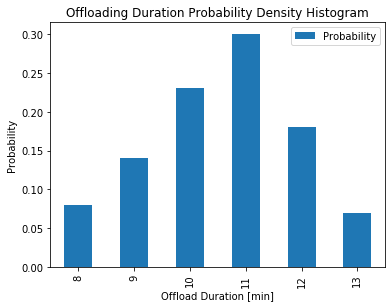

In [3]:
duration_distr = pd.DataFrame(
    [
        [ 8, 0.08],
        [ 9, 0.14],
        [10, 0.23],
        [11, 0.30],
        [12, 0.18],
        [13, 0.07]
    ], 
    columns=['Duration', 'Probability']
)
print(f'sum(offload_duration_prob) = {duration_distr["Probability"].sum()}')
      
fig, ax = plt.subplots(figsize=(6, 4.5))
duration_distr.set_index('Duration').plot(
    kind='bar', 
    title='Offloading Duration Probability Density Histogram', 
    ax=ax
)
ax.set_xlabel('Offload Duration [min]')
ax.set_ylabel('Probability')
plt.show()

if savefigs:
    fig.savefig('figs/offload_prob.png', dpi=800)

## 0.b. Arrival punctuality probability distribution

sum(arrival_distr) = 1.0


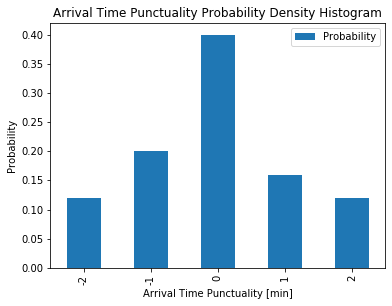

In [4]:
arrival_distr = pd.DataFrame(
    [
        [-2, 0.12],
        [-1, 0.20],
        [ 0, 0.40],
        [ 1, 0.16],
        [ 2, 0.12]
    ], 
    columns=['Arrival', 'Probability']
)
print(f'sum(arrival_distr) = {arrival_distr["Probability"].sum()}')
      
fig, ax = plt.subplots(figsize=(6, 4.5))
arrival_distr.set_index('Arrival').plot(
    kind='bar', 
    title='Arrival Time Punctuality Probability Density Histogram', 
    ax=ax
)
ax.set_xlabel('Arrival Time Punctuality [min]')
ax.set_ylabel('Probability')
plt.show()

if savefigs:
    fig.savefig('figs/arrival_prob.png', dpi=800)

# 1. Functions to generate random numbers using probability distributions

## 1.a. Random offload duration function 

In [5]:
def get_duration(n=1, values=duration_distr['Duration'].values, prob=duration_distr['Probability'].values):
    return np.random.choice(values, n, p=prob)

**Check function works as expected**

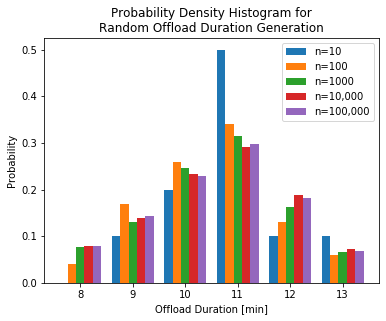

In [6]:
durations = [
    get_duration(10), 
    get_duration(100), 
    get_duration(1000),
    get_duration(10000),
    get_duration(100000),
]

fig, ax = plt.subplots(figsize=(6, 4.5))
ax.hist(
    durations, 
    bins=np.arange(7.5, 13.5+1, 1), 
    density=True
)
ax.set_title('Probability Density Histogram for\nRandom Offload Duration Generation')
ax.set_xlabel('Offload Duration [min]')
ax.set_ylabel('Probability')
ax.legend(['n=10', 'n=100', 'n=1000', 'n=10,000', 'n=100,000'])
plt.show()

if savefigs:
    fig.savefig('figs/offload_duration_distribution.png', dpi=800)

## 1.b. Random arrival punctuality function

In [7]:
def get_arrival(n=1, values=arrival_distr['Arrival'].values, prob=arrival_distr['Probability'].values):
    return np.random.choice(values, n, p=prob)

**Check function works as expected**

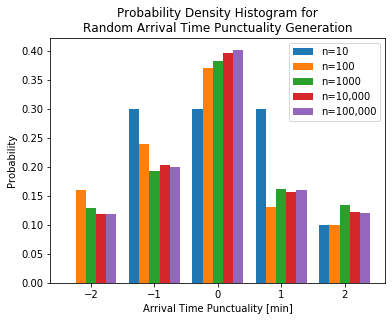

In [8]:
arrival = [
    get_arrival(10), 
    get_arrival(100), 
    get_arrival(1000),
    get_arrival(10000),
    get_arrival(100000),
]

fig, ax = plt.subplots(figsize=(6, 4.5))
ax.hist(
    arrival, 
    bins=np.arange(-2.5, 2.5+1, 1), 
    density=True
)
ax.set_title('Probability Density Histogram for\nRandom Arrival Time Punctuality Generation')
ax.set_xlabel('Arrival Time Punctuality [min]')
ax.set_ylabel('Probability')
ax.legend(['n=10', 'n=100', 'n=1000', 'n=10,000', 'n=100,000'])
plt.show()

if savefigs:
    fig.savefig('figs/arrival_punctuality_distribution.png', dpi=800)

# 2. Function to simulate single goods receipt session

## 2.a. Function

In [9]:
def simulate_session(simulation_period, scheduled_interval):
    # calculate number of trucks to simulate
    n_trucks_sim = int(np.ceil((simulation_period - arrival_distr['Arrival'].min())/scheduled_interval)) # max no. trucks possible

    # generate arrival schedule series
    scheduled_arrival = pd.Series(np.arange(0, n_trucks_sim*scheduled_interval, scheduled_interval), name='arrival_scheduled')
    
    # generate receipt session random input data: offload duration and arrival punctuality
    df = pd.DataFrame(scheduled_arrival)
    df['offload_duration'] = get_duration(n_trucks_sim)
    df['arrival_actual'] = df['arrival_scheduled'] + get_arrival(n_trucks_sim)

    # initialise lists
    start_time = []
    finish_time = []
    wait_time_labour = []
    
    # calculate rows reliant on previous row data (start time and labour wait time)
    for i, row in df.iterrows():
        if (i > 0):
            # start time equals previous finish time, unless truck arrives later
            start_time.append(np.max([row['arrival_actual'], finish_time[i-1]]))
            
            # labour wait time is start time - previous finish time 
            wait_time_labour.append(start_time[i] - finish_time[i-1])
        else:
            # initialise first row
            start_time.append(row['arrival_actual'])
            wait_time_labour.append(0)

        # finish time is start time + offload duration
        finish_time.append(start_time[i] + row['offload_duration'])

    # add lists to data. frame
    df['start_time'] = start_time
    df['start_delta'] =  df['start_time'] - df['arrival_scheduled']

    df['finish_time'] = finish_time
    df['finish_delta'] = df['finish_time'] - (df['arrival_scheduled']+scheduled_interval)

    df['wait_time_labour'] = wait_time_labour
    df['wait_time_truck'] = df['start_time'] - df['arrival_actual']
    
    truck_completion = (simulation_period - df['start_time']) / (df['finish_time'] - df['start_time'])
    truck_completion[truck_completion > 1] = 1
    truck_completion[truck_completion < 0] = 0
    df['truck_completion'] = truck_completion
    
    return df

## 2.b. Test function

### Check output appears as expected

In [10]:
df = simulate_session(simulation_period=180, scheduled_interval=10)

df

,arrival_scheduled,offload_duration,arrival_actual,start_time,start_delta,finish_time,finish_delta,wait_time_labour,wait_time_truck,truck_completion
0,0,11,1,1,1,12,2,0,0,1.000000
1,10,8,10,12,2,20,0,0,2,1.000000
2,20,11,22,22,2,33,3,2,0,1.000000
3,30,13,30,33,3,46,6,0,3,1.000000
4,40,11,40,46,6,57,7,0,6,1.000000
5,50,11,50,57,7,68,8,0,7,1.000000
6,60,9,60,68,8,77,7,0,8,1.000000
7,70,11,68,77,7,88,8,0,9,1.000000
8,80,10,80,88,8,98,8,0,8,1.000000
9,90,10,88,98,8,108,8,0,10,1.000000


### Check summary output data appears reasonable

In [11]:
total_wait_time_labour = (df['wait_time_labour'] * df['truck_completion']).sum()
total_wait_time_truck = (df['wait_time_truck'] * df['truck_completion']).sum()
no_trucks_complete = df['truck_completion'].sum()

print(f'total_wait_time_labour: {total_wait_time_labour:4.0f} min')
print(f'total_wait_time_truck:  {total_wait_time_truck:4.0f} min')
print(f'no_trucks_complete:     {no_trucks_complete:4.1f} trucks')

total_wait_time_labour:    2 min
total_wait_time_truck:   112 min
no_trucks_complete:     16.9 trucks


# 3. Montecarlo simulation of multiple goods receipt sessions

## 3.a. Simulation parameters

In [12]:
n_monte = 10000 # no. simulation loops

simulation_period = 180 # [min] 3h
scheduled_interval = 10 # [min]

## 3.b. Run simulation

In [13]:
results = {
    'total_wait_time_labour': np.zeros(n_monte),
    'total_wait_time_truck': np.zeros(n_monte),
    'no_trucks_complete': np.zeros(n_monte),
}

start_delta = pd.DataFrame()

for j in range(0, n_monte):
    df = simulate_session(simulation_period=simulation_period, scheduled_interval=scheduled_interval)
    
    if j == 0:
        start_delta = pd.DataFrame(df['start_delta']).T
    else:
        start_delta = start_delta.append(df['start_delta'])

    results['total_wait_time_labour'][j] = (df['wait_time_labour'] * df['truck_completion']).sum()
    results['total_wait_time_truck'][j] = (df['wait_time_truck'] * df['truck_completion']).sum()
    results['no_trucks_complete'][j] = df['truck_completion'].sum()

results = pd.DataFrame(results)
start_delta = start_delta

# 4. Simulation output data and plots

In [14]:
results.describe()

,total_wait_time_labour,total_wait_time_truck,no_trucks_complete
count,10000.000000,10000.000000,10000.000000
mean,1.421499,94.614489,16.901392
std,1.871464,37.613722,0.462939
min,0.000000,6.000000,15.181818
25%,0.000000,67.000000,16.583333
50%,1.000000,93.000000,16.909091
75%,2.000000,121.000000,17.230769
max,21.000000,223.909091,18.153846


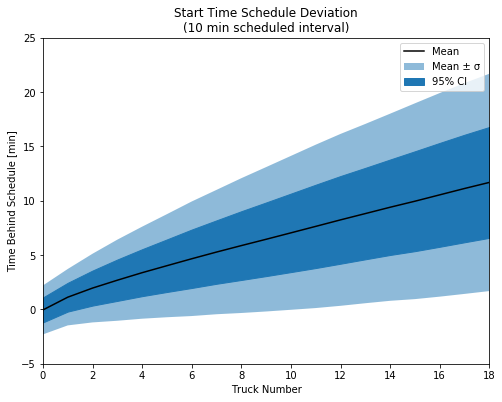

In [15]:
fig, ax = plt.subplots(figsize=(8,6))

mean = start_delta.mean()
x = mean.index

std = start_delta.std()

std_up = mean + std
std_down = mean - std

CI_up = mean + 1.96*std
CI_down = mean - 1.96*std

start_delta.mean().plot(c='k', ax=ax, label='Mean')
ax.fill_between(x, CI_down, CI_up, alpha=0.5, label='Mean ± σ')
ax.fill_between(x, std_down, std_up, color='C0', alpha=1, label='95% CI')

ax.set_title(f'Start Time Schedule Deviation\n({scheduled_interval} min scheduled interval)')
ax.set_xlabel('Truck Number')
ax.set_ylabel('Time Behind Schedule [min]')
ax.legend()

# ax.set_xlim([0,16])
ax.set_ylim([-5,25])

plt.show()

if savefigs:
    fig.savefig(f'figs/schedule_deviation_{scheduled_interval}min.png', dpi=800)
    plt.show()

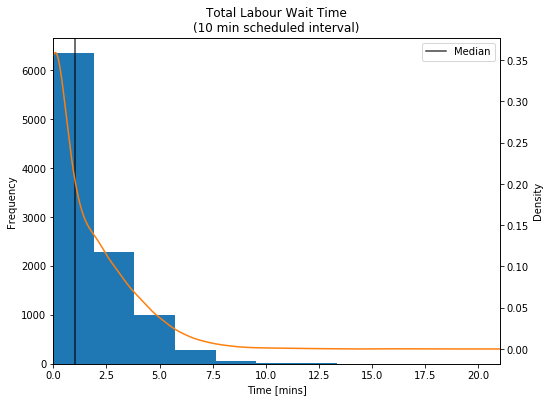

In [23]:
fig, ax = plt.subplots(figsize=(8,6))

results['total_wait_time_labour'].hist(ax=ax, bins='doane')
results['total_wait_time_labour'].plot.kde(ax=ax, secondary_y=True, bw_method=0.3)
ax.axvline(results['total_wait_time_labour'].median(), c='k', alpha=0.75, label='Median')

ax.set_xlim([results['total_wait_time_labour'].min(), results['total_wait_time_labour'].max()])
ax.set(
    title=f'Total Labour Wait Time\n({scheduled_interval} min scheduled interval)', 
    xlabel='Time [mins]', 
    ylabel='Frequency'
)
ax.right_ax.set_ylabel('Density')
ax.legend()

if savefigs:
    fig.savefig(f'figs/total_wait_time_labour_{scheduled_interval}min.png', dpi=800)
plt.show()

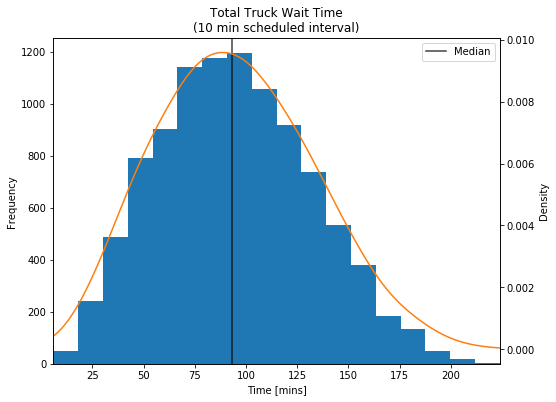

In [17]:
fig, ax = plt.subplots(figsize=(8,6))

results['total_wait_time_truck'].hist(ax=ax, bins='doane')
results['total_wait_time_truck'].plot.kde(ax=ax, secondary_y=True, bw_method=0.3)
ax.axvline(results['total_wait_time_truck'].median(), c='k', alpha=0.75, label='Median')

ax.set_xlim([results['total_wait_time_truck'].min(), results['total_wait_time_truck'].max()])
ax.set(
    title=f'Total Truck Wait Time\n({scheduled_interval} min scheduled interval)', 
    xlabel='Time [mins]', 
    ylabel='Frequency'
)
ax.right_ax.set_ylabel('Density')
ax.legend()

if savefigs:
    fig.savefig(f'figs/total_wait_time_truck_{scheduled_interval}min.png', dpi=800)
plt.show()

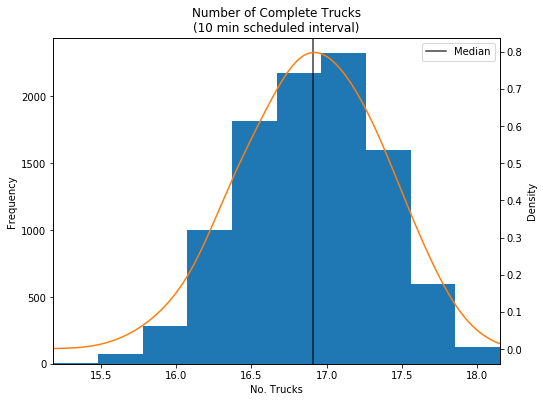

In [22]:
fig, ax = plt.subplots(figsize=(8,6))

results['no_trucks_complete'].hist(ax=ax, bins='doane')
results['no_trucks_complete'].plot.kde(ax=ax, secondary_y=True, bw_method=0.3)
ax.axvline(results['no_trucks_complete'].median(), c='k', alpha=0.75, label='Median')

ax.set_xlim([results['no_trucks_complete'].min(), results['no_trucks_complete'].max()])
ax.set(
    title=f'Number of Complete Trucks\n({scheduled_interval} min scheduled interval)', 
    xlabel='No. Trucks', 
    ylabel='Frequency'
)
ax.right_ax.set_ylabel('Density')
ax.legend()

if savefigs:
    fig.savefig(f'figs/no_trucks_complete_{scheduled_interval}min.png', dpi=800)
plt.show()